# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо 
- обучить модель классифицировать комментарии на позитивные и негативные. 
- построить модель со значением метрики качества *F1* не меньше 0.75. 

In [8]:
# !pip install textblob

In [31]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re 

from tqdm import notebook
import torch
import transformers

from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, recall_score, precision_score,roc_auc_score, roc_curve,precision_recall_curve
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from catboost import Pool, CatBoostRegressor,cv,CatBoost,CatBoostClassifier
from catboost.utils import eval_metric
from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from textblob import TextBlob, Word

from scipy.stats import uniform
matplotlib.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,LinearSVC,NuSVC

## Осмотр данных

In [10]:
data = pd.read_csv (r"C:\Users\Integro\Desktop\Обучение\YandexPracticum\Sprint 12\toxic_comments.csv")

Проверим на  наличие пропусков.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


**Комментарий:** пропуски отсутствуют.

In [12]:
data.loc[data['text'].str.isspace() == True]

,text,toxic


## Предобработка данных.

In [13]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Так как комментарии содержат левые символы, то оставим только текст.

In [14]:
def clear_text(text):
    text  = re.sub(r"[^a-zA-Z']", ' ', text)
    return " ".join(text.split())

In [15]:
%%time
data['clear_text'] = data['text'].apply(clear_text)

Wall time: 4.88 s


Для решения задачи в  данном пункте предобработки данных потребуется лемматизция текста. Используем `TextBlob Lemmatizer`, так как относительно быстрый по сравнени с остальными

In [16]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)


In [17]:
%%time
data['lemma_text'] = data['clear_text'].apply(lemmatize_with_postag)

Wall time: 11min 38s


In [18]:
data_copy = data.drop(['text','clear_text'],axis = 1)

In [19]:
data.head()

,text,toxic,clear_text,lemma_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D'aww He matches this background colour I'm se...,D'aww He match this background colour I 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I'm really not trying to edit war It's...,Hey man I 'm really not try to edit war It 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can't make any real suggestions on impr...,More I ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir be my hero Any chance you remember wha...


### Разделение выборок на обучающую и тестовую

In [20]:
target = data_copy['toxic']
features = data_copy['lemma_text']
features_train, features_test,target_train,target_test = train_test_split (features, target , test_size = 0.25, random_state=393, stratify = target)
# Используем параметр stratify = target сделаем разделение таким образом, чтобы доля значений с признаком 1 рассплитилась в том же соотношении, что и  features, test

Проверим разбиение

In [21]:
display(
    features_train.shape,
    target_train.shape,
    features_test.shape,
    target_test.shape
)

(119678,)

(119678,)

(39893,)

(39893,)

### Преобразование текста в вектора

Так как  работаем с текстом проведем преобразование в векторный вид

Загрузим список английских стоп-слов

In [22]:
corpus_train = features_train.values.astype('U')
corpus_test = features_test.values.astype('U')
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Integro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим счетчик TF-IDF, передадим в него английские стоп-слова

In [23]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

## Обучение

### Оценка дисбаланса

In [24]:
data['toxic'].value_counts(normalize=True).to_frame().style.format('{:.2%}')

,toxic
0,89.83%
1,10.17%


**Комментарий:** 
1. как мы видим в датасете дисбаланс классов.
2. для оценки понадобится метрика F1 и матрица путаницы.
3. проверим, как будет изменяться основная метрика  F1 при уменьшении выборки

### LogisticRegression.
Сформируем  модель  без ребалансировки классов

In [18]:
%%time
logistic = LogisticRegression(max_iter=200, tol=1e-2,)
distributions = dict(C=uniform(loc=0, scale=10),penalty=['l2', 'l1'], solver = ['liblinear','saga'],class_weight = ['balanced', None] )
clf = RandomizedSearchCV(logistic, distributions,n_jobs=-1, cv = 5, random_state=393,scoring='f1')
search_lr = clf.fit(tf_idf, target_train)

Wall time: 3min 33s


In [19]:
results = clf.cv_results_
print('Лучшие параметры - ',search_lr.best_params_)
print(f'Лучшая метрика F1 - {search_lr.best_score_:.3f}')
print('Лучшая модель - ', search_lr.best_estimator_)
# print(results)

Лучшие параметры -  {'C': 3.694728121513565, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Лучшая метрика F1 - 0.772
Лучшая модель -  LogisticRegression(C=3.694728121513565, max_iter=200, penalty='l1',
                   solver='saga', tol=0.01)


In [20]:
%%time
corpus_test = features_test.values.astype('U')
tf_idf_test = count_tf_idf.transform(corpus_test)
test_prediction_lr = search_lr.best_estimator_.predict(tf_idf_test)
f1_lr_test = f1_score(target_test,test_prediction_lr)
print('F1 - {:.2%}'.format(f1_lr_test))

F1 - 78.04%
Wall time: 3.33 s


### Борьба с дисбалансом. Уменьшение выборки (Downsampling)

Попробуем метод даунсэмплинга, возможно это улучшит наши результаты

Вместо повторения токсичных комментариев, уберём часть нетоксичных. 
Преобразование проведем в несколько этапов:

- Разделим обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросим часть из отрицательных объектов;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [21]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=fraction, random_state=42)
    target_sample = target_zeros.sample(frac=fraction, random_state=42)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=42)
    target_downsampled = shuffle(target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [22]:
for frac in np.arange(1,0.1,-0.2): 
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
    corpus_train_ds = features_downsampled.values.astype('U')
    tf_idf_ds = count_tf_idf.fit_transform(corpus_train_ds)
    lr_tf_idf_ds = LogisticRegression(random_state=393)
    f1_cv= cross_val_score(lr_tf_idf_ds, tf_idf_ds,target_downsampled,n_jobs = -1, cv=3,scoring = 'f1').mean() 
    print("F1:  {:.2%}.  Сокращение строк с нулевым признаком на : {:.2%}".format( f1_cv,1-frac))

F1:  69.77%.  Сокращение строк с нулевым признаком на : 0.00%
F1:  71.13%.  Сокращение строк с нулевым признаком на : 20.00%
F1:  73.57%.  Сокращение строк с нулевым признаком на : 40.00%
F1:  77.00%.  Сокращение строк с нулевым признаком на : 60.00%
F1:  82.90%.  Сокращение строк с нулевым признаком на : 80.00%


**Комменатарий:** Как мы видим, приближаясь к соотношению 50/50 между нулевым классом и единицей метрика f1  растет 

In [23]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.9)
corpus_train_ds = features_downsampled.values.astype('U')
tf_idf_ds = count_tf_idf.fit_transform(corpus_train_ds)


### LogisticRegression Downsampling

In [24]:
%%time
logistic = LogisticRegression(max_iter=200, tol=1e-2,)
distributions = dict(C=uniform(loc=0, scale=10),penalty=['l2', 'l1'], solver = ['liblinear','saga'])
clf = RandomizedSearchCV(logistic, distributions,n_jobs=-1, cv = 5, random_state=393,scoring='f1')#,return_train_score=True,refit='f1'
search_ds = clf.fit(tf_idf_ds, target_downsampled)
results = clf.cv_results_

Wall time: 31.7 s


In [25]:
results_ds = clf.cv_results_
print('Лучшие параметры - ',search_ds.best_params_)
print(f'Лучшая метрика F1 - {search_ds.best_score_:.3f}')
print('Лучшая модель - ', search_ds.best_estimator_)
# print(results)

Лучшие параметры -  {'C': 1.9942561642299106, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая метрика F1 - 0.775
Лучшая модель -  LogisticRegression(C=1.9942561642299106, max_iter=200, penalty='l1',
                   solver='liblinear', tol=0.01)


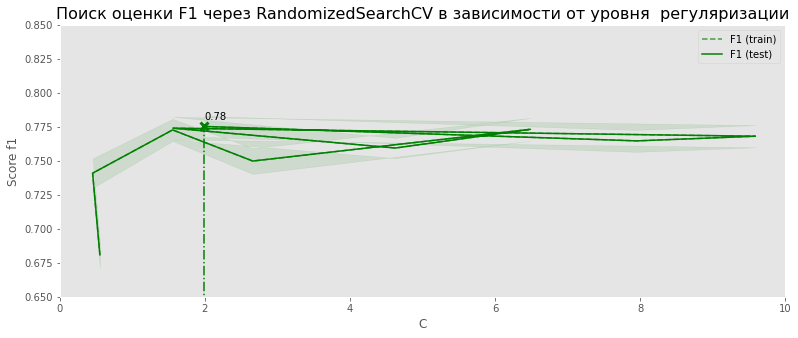

In [26]:
plt.figure(figsize=(13, 5))
plt.title("Поиск оценки F1 через RandomizedSearchCV в зависимости от уровня  регуляризации", fontsize=16)

plt.xlabel("C")
plt.ylabel("Score f1")

ax = plt.gca()
ax.set_xlim(0, 10)
ax.set_ylim(0.65, 0.85)

# Get the regular numpy array from the MaskedArray

scoring = {"F1": "f1"}
results_list= results['params']
results_x = [element['C'] for element in results_list]

X_axis = np.array(results_x, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_test_score"]
        sample_score_std = results["std_test_score"]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_score"] == 1)[0][0]
    best_score = results['mean_test_score'][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### Проверим модель на тесте 

In [27]:
%%time
corpus_test = features_test.values.astype('U')
tf_idf_test_ds = count_tf_idf.transform(corpus_test)
test_prediction_ds = search_ds.best_estimator_.predict(tf_idf_test_ds)
f1_lr__ds_test =f1_score(target_test,test_prediction_ds)
print('F1 - {:.2%}'.format(f1_lr__ds_test))

F1 - 78.55%
Wall time: 3.25 s


## LGBM

In [28]:
%%time
tf_idf = count_tf_idf.fit_transform(corpus_train)

lgbm = LGBMClassifier(random_state=393, learning_rate = 0.4 )
f1_cv_lgbm= cross_val_score(lgbm, tf_idf,target_train,n_jobs = -1, cv=3,scoring = 'f1').mean()
print(f'метрика F1 - {f1_cv:.2f}')

метрика F1 - 0.83
Wall time: 55 s


In [29]:
distributions = dict(learning_rate =list(np.arange(0.1,0.3,0.1)),boosting_type = ['gbdt','goss'])
clf_lgbm = GridSearchCV(lgbm, distributions,n_jobs=-1, cv = 3, scoring='f1',return_train_score=True,refit='f1')
search_lgbm = clf_lgbm.fit(tf_idf, target_train)

In [30]:
print('Лучшие параметры - ',search_lgbm.best_params_)
print(f'Лучшая метрика F1 - {search_lgbm.best_score_:.3f}')
print('Лучшая модель - ', search_lgbm.best_estimator_)

Лучшие параметры -  {'boosting_type': 'gbdt', 'learning_rate': 0.2}
Лучшая метрика F1 - 0.757
Лучшая модель -  LGBMClassifier(learning_rate=0.2, random_state=393)


Проверка на тесте

In [31]:
corpus_test = features_test.values.astype('U')
tf_idf_test = count_tf_idf.transform(corpus_test)
test_prediction__lgbm = search_lgbm.best_estimator_.predict(tf_idf_test)
f1_lgbm_test = f1_score(target_test,test_prediction__lgbm)
print('F1 - {:.2%}'.format(f1_lgbm_test))

F1 - 76.17%


In [32]:
print (tf_idf_test.shape)
print(tf_idf.shape)
print(features_train.shape)

(39893, 135965)
(119678, 135965)
(119678,)


### CatBoost_default

In [33]:
%%time
classificator = CatBoostClassifier(verbose=False, iterations=200)
cv_f1_CBC = cross_val_score(classificator,tf_idf,target_train,cv=3,scoring='f1').mean()
print('F1 на cv {:.2%}'.format(cv_f1_CBC))

F1 на cv 72.97%
Wall time: 14min 42s


Проверка на тесте

In [34]:
%%time
search_cb =classificator.fit(tf_idf, target_train)
target_predict = classificator.predict(tf_idf_test)
test_f1_cbc = f1_score(target_test, target_predict)
print('F1 на тесте {:.2%}'. format(test_f1_cbc))

F1 на тесте 74.73%
Wall time: 5min 11s


### DummyClassifier

Проверим метрику  f1  константной  модели.

In [35]:
dummy_model = DummyClassifier(strategy='constant',constant=1, random_state=393).fit(tf_idf,target_train)
predictions_test = dummy_model.predict(tf_idf_test)
f1_dummy=f1_score(target_test, predictions_test)
print(f'{f1_dummy:.2f}')

0.18


### ROC_AUC_score

Подготовим функцию plot ROC_AUC

In [36]:
def roc_auc_plot(model,label,features_test, target_test):
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    plt.plot(fpr, tpr, label=label)

Построим ROC_AUC

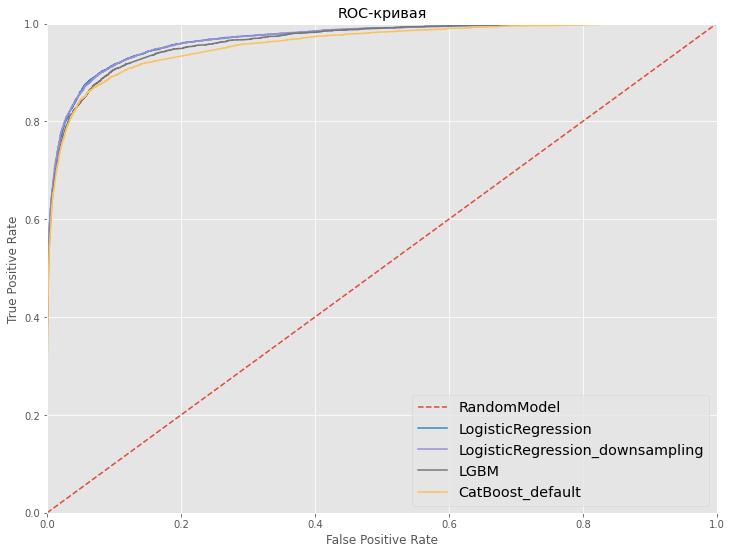

In [37]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

roc_auc_plot(search_lr,'LogisticRegression',tf_idf_test,target_test)
roc_auc_plot(search_ds,'LogisticRegression_downsampling',tf_idf_test_ds,target_test)
roc_auc_plot(search_lgbm,'LGBM',tf_idf_test,target_test)
roc_auc_plot(search_cb,'CatBoost_default',tf_idf_test,target_test)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая")
plt.show()

Соберем метрики f1 в таблицу

In [38]:
dick_f1 = { 'LogisticRegression': [search_lr.best_score_,f1_lr_test],  'LogisticRegression_downsampling': [search_ds.best_score_,f1_lr__ds_test], 'LGBM':[f1_cv_lgbm,f1_lgbm_test] , 'CatBoost_default': [cv_f1_CBC,test_f1_cbc],'DummyClassifier':[f1_dummy,f1_dummy]}
pd.DataFrame(dick_f1, index = ['f1_train','f1_test']).style.format('{:.2%}')

,LogisticRegression,LogisticRegression_downsampling,LGBM,CatBoost_default,DummyClassifier
f1_train,77.16%,77.54%,76.15%,72.97%,18.46%
f1_test,78.04%,78.55%,76.17%,74.73%,18.46%


**Вывод:** В целом, модели достаточно близки по своей метрике, но лучшая LogisticRegression. Все они преодолевают порог адекватности в 18.46% 


### Матрица ошибок

Для лучшей  модели построим матрицу ошибок, посмотрим на изменение  precision и recall при изменении порога

In [39]:
cm=confusion_matrix(target_test, test_prediction_lr)

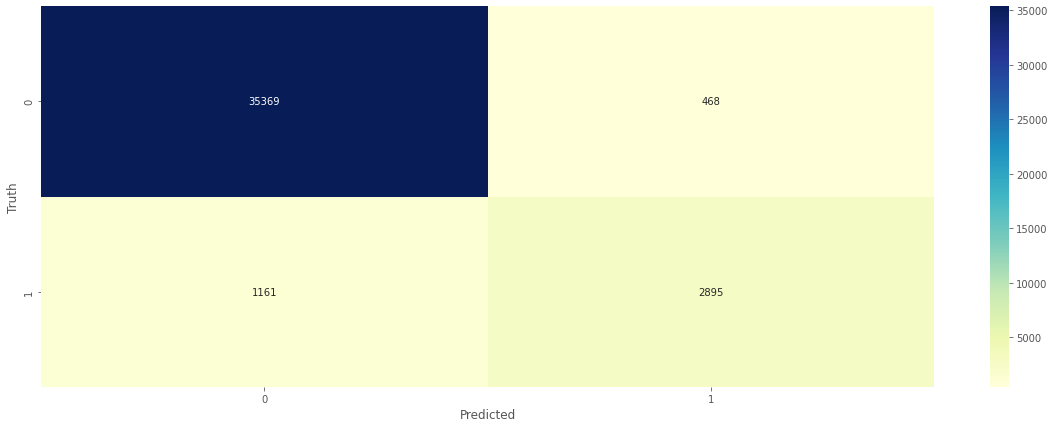

In [40]:
plt.figure(figsize = (20,7))
sns.heatmap(cm, annot=True, fmt='d',cmap='YlGnBu');
plt.xlabel('Predicted');
plt.ylabel('Truth');

In [41]:
print('recall - {:.2%}'.format(recall_score(target_test, test_prediction_lr)))

recall - 71.38%


In [42]:
print('precision - {:.2%}'.format(precision_score(target_test, test_prediction_lr)))

precision - 86.08%


### Регулировка порога

In [43]:
probabilities = search_lr.predict_proba(tf_idf)
probabilities_one = probabilities[:, 1]
list_metrix=[]
for threshold in np.arange(0, 1, 0.1):
    predicted = probabilities_one > threshold
    precision = precision_score(target_train, predicted)
    recall = recall_score(target_train, predicted)
    f1 = f1_score(target_train, predicted)
    list_metrix.append([precision,recall,f1])

In [45]:
columns =['precision','recall','f1']
pd.DataFrame(list_metrix,columns=columns).style.format('{:.2%}')

,precision,recall,f1
0,10.17%,100.00%,18.46%
1,67.31%,97.06%,79.50%
2,80.71%,93.86%,86.79%
3,86.82%,89.71%,88.24%
4,90.79%,84.51%,87.54%
5,93.52%,78.69%,85.47%
6,95.20%,72.79%,82.50%
7,96.68%,67.20%,79.28%
8,97.79%,61.37%,75.41%
9,98.57%,54.56%,70.25%


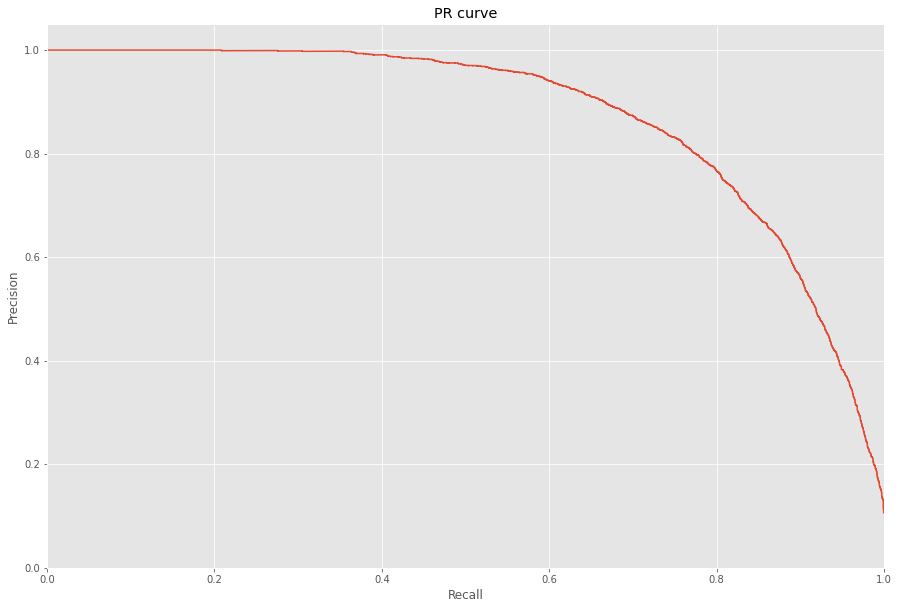

In [46]:
probabilities = search_lr.predict_proba(tf_idf_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities[:, 1])    
plt.figure(figsize=(15, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

**Выводы:** 
- precision 87.24%- точность. Модель достаточно неплохо предсказывает токсичные комментарии,  чуть больше 12% нетоксичных комментариев модель забраковала, то есть пометила, как  токсичные.
- recall 70.78% - полнота. Модель, можно сказать, осторожничает, 30 % из всех токсичных комментариев пометила, как нетоксичные.
- также  для заказчика  в пункте **Регулировка порога**  представлена матрица соотношения precision и recall, в случае необходимости изменения характеристик precision,recall .

## Выводы

По результатам проведенной работы мы создали модель, которая соответствует требованиям заказчика, а именно, метрика F1 > 75% . Наилучшая метрика достигнута моделью **Логистической регрессии** и составляет **F1 - 78.15%**

### Модель Bert (Bonus ) озакомительно

Учтём, что модель BERT очень требовательна к ресурсам, поэтому построим модель, не претендуя на высокий результатам меры F1.

In [97]:
df_bert = data.sample(30000).reset_index(drop=True)


Проведем токенизацию (преобразуем каждое предложение в список идентификаторов, максимальная длина = 512, но для экономии времени обучения ограничимся длиной = 20). Лемматизация не требуется, так как BERT понимает формы слов

In [ ]:
%%time
tokenizer = transformers.BertTokenizer(
    vocab_file='vocab.txt')

tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, max_length=20, truncation=True,add_special_tokens = True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Загружаем предобученную модель и токенизатор BERT 

In [ ]:
config = transformers.BertConfig.from_json_file("bert_config.json")
model = transformers.BertModel.from_pretrained("pytorch_model.bin", config=config)

Используем обученный BERT для создания эмбеддингов для каждого текста по 50 текстов в батче

In [ ]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())

Объединяем эмбеддинги для каждого текста

In [ ]:
features_bert = np.concatenate(embeddings)
target = df_bert['toxic']

Сплитанем выборки на обучем её LogisticRegression

In [ ]:
train_features, test_features, train_target, test_target = train_test_split(features_bert, target, test_size=.75, stratify = target)

In [ ]:
model = LogisticRegression(max_iter=500,random_state=393).fit(train_features, train_target)

In [ ]:
test_prediction = model.predict(test_features)

In [ ]:
print('F1 - {:.2%}'.format(f1_score(test_target,test_prediction)))

## Выводы по Bert: 

В целом , модель получилась с метрикой f1 -60.48,что  выше порога адекватности в 18.46%, но недостаточно для достижения целевых показателей. Из плюсов Bert можно отметить отсутствие требований к лемматизации текста,  а к минусам более существенные требования к вычислительным ресурсам компьютера.

Поробуем  завернуть часть работы по обучению и подбору  гиперпараметров в Pipeline

### Pipe_line - продемострируем возможности через пайплайн

In [47]:
%%time
pipe = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
        ('model', 'passthrough',), 
               ])

params = [
        {
       'model': (LogisticRegression(random_state=393, max_iter=500),),
       'model__solver': ('liblinear','saga',),
       'model__C': (1,2,5,),
       'model__penalty':('l1','l2',), 
        },
        {'model':(LGBMClassifier(random_state=393),),
        'model__learning_rate': (0.2,0.4,),
        },
        {
         'model': (DummyClassifier(strategy='constant',constant=1, random_state=393),)
        }
]

grid = GridSearchCV(pipe, param_grid=params, scoring='f1',n_jobs=-1, cv=2, verbose=10,return_train_score=True, refit=True)
search_pipe = grid.fit(features_train, target_train)


Fitting 2 folds for each of 15 candidates, totalling 30 fits
Wall time: 7min 38s


In [48]:
print('Лучшие параметры модели - ',search_pipe.best_params_['model'])
print(f'Лучшая метрика F1 - {search_pipe.best_score_:.3f}')

Лучшие параметры модели -  LogisticRegression(C=2, max_iter=500, penalty='l1', random_state=393,
                   solver='liblinear')
Лучшая метрика F1 - 0.778


**Best модель на тесте**

In [49]:
test_prediction_best_model = search_pipe.predict(features_test)
f1_bm_test =f1_score(target_test,test_prediction_best_model)
print('F1 - {:.2%}'.format(f1_bm_test))

F1 - 79.17%


In [50]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.9)

In [51]:
%%time
search_ds = grid.fit(features_downsampled, target_downsampled)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Wall time: 21min 3s


c:\users\integro\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
print('Лучшие параметры модели - ',search_ds.best_params_['model'])
print(f'Лучшая метрика F1 - {search_ds.best_score_:.3f}')

Лучшие параметры модели -  LogisticRegression(C=5, max_iter=500, penalty='l1', random_state=393,
                   solver='saga')
Лучшая метрика F1 - 0.782


**Best модель downsampled на тесте**

In [53]:
test_prediction_best_model_ds = search_ds.predict(features_test)
f1_bm_test_ds =f1_score(target_test,test_prediction_best_model_ds)
print('F1 - {:.2%}'.format(f1_bm_test_ds))

F1 - 79.29%


In [54]:
cm=confusion_matrix(target_test, test_prediction_best_model_ds)
pd.DataFrame(cm)

,0,1
0,35300,537
1,1039,3017


In [55]:
probabilities = search_ds.predict_proba(features_train)
probabilities_one = probabilities[:, 1]
list_metrix=[]
for threshold in np.arange(0, 1, 0.1):
    predicted = probabilities_one > threshold
    precision = precision_score(target_train, predicted)
    recall = recall_score(target_train, predicted)
    f1 = f1_score(target_train, predicted)
    list_metrix.append([precision,recall,f1])
columns =['precision','recall','f1']
pd.DataFrame(list_metrix,columns=columns).style.format('{:.2%}')

,precision,recall,f1
0,10.17%,100.00%,18.46%
1,69.29%,98.90%,81.49%
2,81.37%,97.50%,88.71%
3,87.68%,95.36%,91.36%
4,91.64%,92.15%,91.90%
5,94.24%,88.02%,91.02%
6,96.01%,82.23%,88.58%
7,97.22%,74.53%,84.37%
8,98.01%,67.10%,79.66%
9,98.75%,59.68%,74.40%


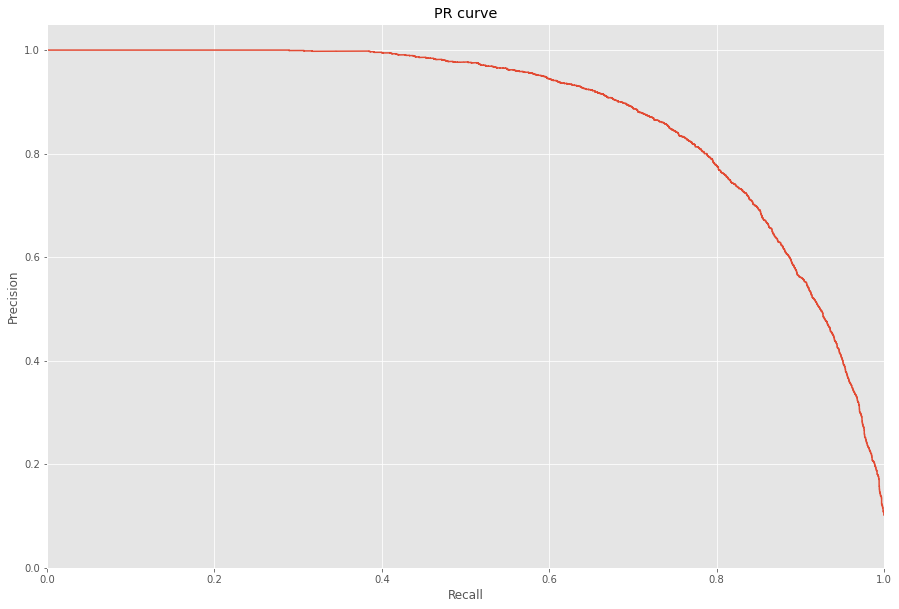

In [56]:
probabilities = search_ds.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities[:, 1])    
plt.figure(figsize=(15, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

### Cat_boost - Собственные  инструменты Cat_boost

In [67]:
text_features=data[['lemma_text']]

In [108]:
# from pattern.en import lemma
from catboost.text_processing import Tokenizer


In [98]:
train_pool = Pool(features_train.to_frame(), target_train.to_frame(),
                  text_features= ['lemma_text'])
valid_pool = Pool(features_test.to_frame(), target_test.to_frame(),
                  text_features= ['lemma_text'])

In [111]:

def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(task_type='CPU', iterations = 5000,
                               eval_metric='F1', od_type='Iter', 
                               od_wait=500, **kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)

In [112]:
model = fit_model(train_pool, valid_pool, learning_rate=0.35,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                   tokenizers=[
                    {
                        'tokenizer_id': 'Sense',
                        'separator_type': 'BySense',
                        'lowercasing': 'True',
                        'token_types':['Word', 'Number', 'SentenceBreak'],
                        'sub_tokens_policy':'SeveralTokens'
                    }      
                            ],
                 feature_calcers = ['BoW','NaiveBayes'])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6996440	test: 0.7151699	best: 0.7151699 (0)	total: 123ms	remaining: 10m 15s
100:	learn: 0.7942959	test: 0.7723178	best: 0.7752363 (79)	total: 13.9s	remaining: 11m 12s
200:	learn: 0.8210860	test: 0.7749729	best: 0.7763517 (117)	total: 27.4s	remaining: 10m 54s
300:	learn: 0.8374978	test: 0.7750846	best: 0.7773411 (283)	total: 41.1s	remaining: 10m 42s
400:	learn: 0.8510505	test: 0.7746117	best: 0.7773411 (283)	total: 54.9s	remaining: 10m 29s
500:	learn: 0.8623298	test: 0.7755157	best: 0.7773411 (283)	total: 1m 8s	remaining: 10m 19s
600:	learn: 0.8718767	test: 0.7779125	best: 0.7784512 (591)	total: 1m 22s	remaining: 10m 5s
700:	learn: 0.8813828	test: 0.7801342	best: 0.7822581 (673)	total: 1m 36s	remaining: 9m 51s
800:	learn: 0.8899433	test: 0.7780763	best: 0.7822581 (673)	total: 1m 50s	remaining: 9m 37s
900:	learn: 0.8971121	test: 0.7770906	best: 0.7822581 (673)	total: 2m 4s	remaining: 9m 27s
1000:	learn: 0.9033972	test: 0.7789276	best: 0.7822581 (673)	total: 2m 19s	remaining: 

In [33]:
%%time
classificator = SVC(  class_weight ='balanced')
cv_f1_svc = cross_val_score(classificator,tf_idf,target_train,cv=3,scoring='f1',n_jobs = -1).mean()
print('F1 на cv {:.2%}'.format(cv_f1_svc))

F1 на cv 76.59%
Wall time: 41min 28s
